In [1]:
import pandas as pd

# Step 1: Load the dataset
file_path = 'creditcard.csv'
df = pd.read_csv(file_path)

# Step 2: Show basic info about the dataset
print(df.info())
print(df.head())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49610 entries, 0 to 49609
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    49610 non-null  int64  
 1   V1      49610 non-null  float64
 2   V2      49610 non-null  float64
 3   V3      49610 non-null  float64
 4   V4      49609 non-null  float64
 5   V5      49609 non-null  float64
 6   V6      49609 non-null  float64
 7   V7      49609 non-null  float64
 8   V8      49609 non-null  float64
 9   V9      49609 non-null  float64
 10  V10     49609 non-null  float64
 11  V11     49609 non-null  float64
 12  V12     49609 non-null  float64
 13  V13     49609 non-null  float64
 14  V14     49609 non-null  float64
 15  V15     49609 non-null  float64
 16  V16     49609 non-null  float64
 17  V17     49609 non-null  float64
 18  V18     49609 non-null  float64
 19  V19     49609 non-null  float64
 20  V20     49609 non-null  float64
 21  V21     49609 non-null  float64
 22

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
Class distribution:
 Class
0.0    49461
1.0      148
Name: count, dtype: int64


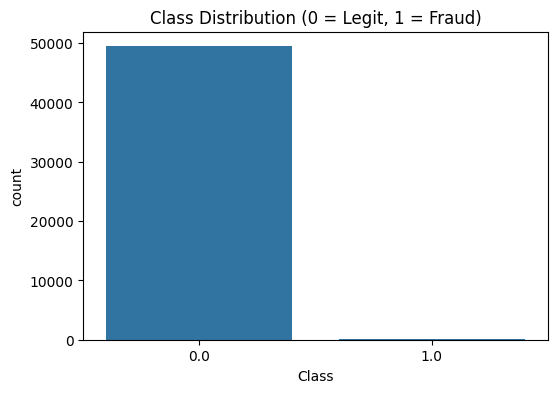

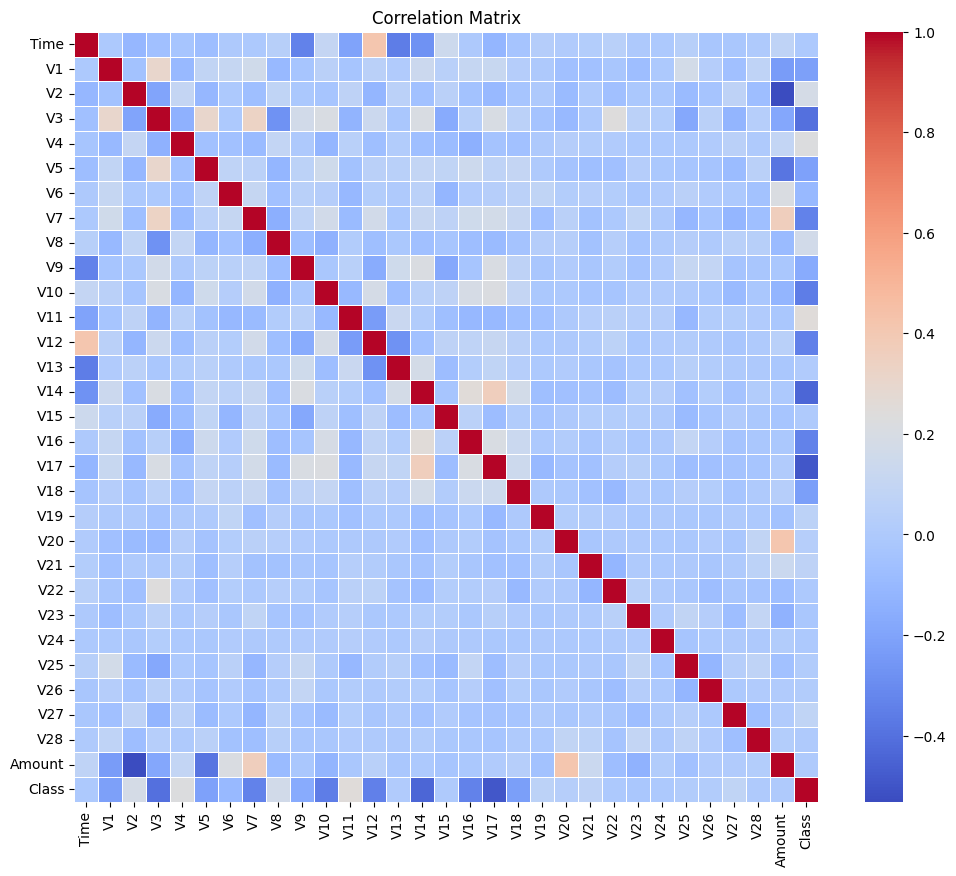

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
print("Class distribution:\n", df['Class'].value_counts())

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.show()

# Plot correlations (optional heavy computation)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Drop any rows with NaN values (just in case)
df_cleaned = df.dropna()

# Step 2: Separate features and target
X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Confirm new balance
print("After SMOTE, class distribution:\n", pd.Series(y_train_resampled).value_counts())


After SMOTE, class distribution:
 Class
0.0    39572
1.0    39572
Name: count, dtype: int64


In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

# Reduce dimensionality for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Fit KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_pca)
y_pred_kmeans = kmeans.labels_

# Map clusters to binary class (choose the mapping that gives higher AUC)
auc1 = roc_auc_score(y, y_pred_kmeans)
auc2 = roc_auc_score(y, 1 - y_pred_kmeans)

final_preds = y_pred_kmeans if auc1 > auc2 else 1 - y_pred_kmeans

print("📌 KMeans Clustering (k=2)")
print("ROC AUC Score:", max(auc1, auc2))


📌 KMeans Clustering (k=2)
ROC AUC Score: 0.5045926848180139


In [5]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_pca)
y_pred_gmm = gmm.predict(X_pca)

auc1 = roc_auc_score(y, y_pred_gmm)
auc2 = roc_auc_score(y, 1 - y_pred_gmm)
final_preds_gmm = y_pred_gmm if auc1 > auc2 else 1 - y_pred_gmm

print("📌 GMM")
print("ROC AUC Score:", max(auc1, auc2))


📌 GMM
ROC AUC Score: 0.9064275730209495


In [6]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.0017, random_state=42)
iso.fit(X)
y_pred_iso = iso.predict(X)
y_pred_iso_binary = (y_pred_iso == -1).astype(int)

print("📌 Isolation Forest")
print("ROC AUC Score:", roc_auc_score(y, y_pred_iso_binary))


📌 Isolation Forest
ROC AUC Score: 0.6787305668621251


In [7]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017, novelty=True)
lof.fit(X)
y_pred_lof = lof.predict(X)
y_pred_lof_binary = (y_pred_lof == -1).astype(int)

print("📌 Local Outlier Factor")
print("ROC AUC Score:", roc_auc_score(y, y_pred_lof_binary))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


📌 Local Outlier Factor
ROC AUC Score: 0.5332277901726558


In [8]:
from sklearn.covariance import EllipticEnvelope

env = EllipticEnvelope(contamination=0.0017)
env.fit(X)
y_pred_env = env.predict(X)
y_pred_env_binary = (y_pred_env == -1).astype(int)

print("📌 Elliptic Envelope")
print("ROC AUC Score:", roc_auc_score(y, y_pred_env_binary))


/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-294.049178741662445 > -294.391047679826613). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-238.505428824991213 > -266.958632088382103). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-128.960653462839957 > -135.408076155661405). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
/usr/local

📌 Elliptic Envelope
ROC AUC Score: 0.5025292244995648


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score # Import necessary functions

model14 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model14.fit(X_train_resampled, y_train_resampled)
y_pred14 = model14.predict(X_test)
y_proba14 = model14.predict_proba(X_test)[:, 1]

print("📌 XGBoost")
print(confusion_matrix(y_test, y_pred14))
print(classification_report(y_test, y_pred14, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba14))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:22:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 XGBoost
[[9887    2]
 [   1   32]]
              precision    recall  f1-score   support

         0.0     0.9999    0.9998    0.9998      9889
         1.0     0.9412    0.9697    0.9552        33

    accuracy                         0.9997      9922
   macro avg     0.9705    0.9847    0.9775      9922
weighted avg     0.9997    0.9997    0.9997      9922

ROC AUC: 0.9999816140983094


In [11]:
from sklearn.neural_network import MLPClassifier

model15 = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000)
model15.fit(X_train_resampled, y_train_resampled)
y_pred15 = model15.predict(X_test)
y_proba15 = model15.predict_proba(X_test)[:, 1]

print("📌 Neural Network (MLP)")
print(confusion_matrix(y_test, y_pred15))
print(classification_report(y_test, y_pred15, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba15))


📌 Neural Network (MLP)
[[9825   64]
 [   1   32]]
              precision    recall  f1-score   support

         0.0     0.9999    0.9935    0.9967      9889
         1.0     0.3333    0.9697    0.4961        33

    accuracy                         0.9934      9922
   macro avg     0.6666    0.9816    0.7464      9922
weighted avg     0.9977    0.9934    0.9950      9922

ROC AUC: 0.9991511842052847
